<a href="https://colab.research.google.com/github/lenmoru666/MachineLearning_Ganjil_2023/blob/main/Job_Sheet_12_Optical_Character_Recognition_(OCR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Nama : Falendika Tegar Pratama
### Kelas : 3G-TI
### Nim : 2141720107

#### Link Github : (https://github.com/lenmoru666/MachineLearning_Ganjil_2023/blob/main/Job_Sheet_12_Optical_Character_Recognition_(OCR).ipynb)

# Praktikum 1 - OCR with Pytesseract and OpenCV


## Deskripsi

Pada praktikum ini kita akan menerapkan teknik OCR dengan menggunakan tesseract dan openCV. Pytesseract or Python-tesseract merupakan alat OCR untuk Python yang juga berfungsi sebagai pembungkus untuk Mesin OCR Tesseract. Ia dapat membaca dan mengenali teks dalam gambar dan umumnya digunakan dalam kasus penggunaan ocr gambar ke teks menggunakan Python.

Selain itu juga berguna sebagai skrip panggilan mandiri untuk tesseract, karena dapat membaca semua jenis gambar yang didukung oleh perpustakaan gambar Pillow dan Leptonica, termasuk jpeg, png, gif, bmp, tiff, dan lainnya.

referensi lebih lengkap terkait pendekatan Python-tesseract dapat dibaca di [sini](https://github.com/madmaze/pytesseract).

## Dataset

Dataset merupakan data citra yang digunakan dalam praktikum ini, pastikan koneksi Anda sebelum mengunduh dataset.

## Persiapan data

In [5]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalasi dan Import Library

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,948 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
import re
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [ ]:
IMG_DIR = '/content/drive/MyDrive/ML/Jobsheet 12/images/'

## Preprocessing images dengan OpenCV

Pada tahap ini kita akan akan menulis fungsi dasar untuk metode prapemrosesan yang berbeda, meliputi:
- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching

Metode yang berbeda dapat berguna untuk jenis gambar yang berbeda

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

Mari kita bekerja dengan sebuah contoh Image untuk melihat segalanya dengan lebih baik. Seperti inilah gambar asli sebelum di proses

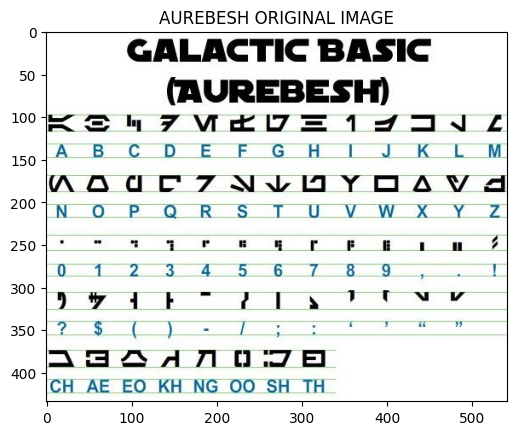

In [ ]:
# Plot original image

image = cv2.imread(IMG_DIR + 'aurebesh.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('AUREBESH ORIGINAL IMAGE')
plt.show()

Selanjutnya lakukan pre-processing, dan setelah dilakukan preprocessing dengan kode berikut, makan akan didapatkan hasil image baru

In [ ]:
# Preprocess image

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray,
          'thresh': thresh,
          'opening': opening,
          'canny': canny}

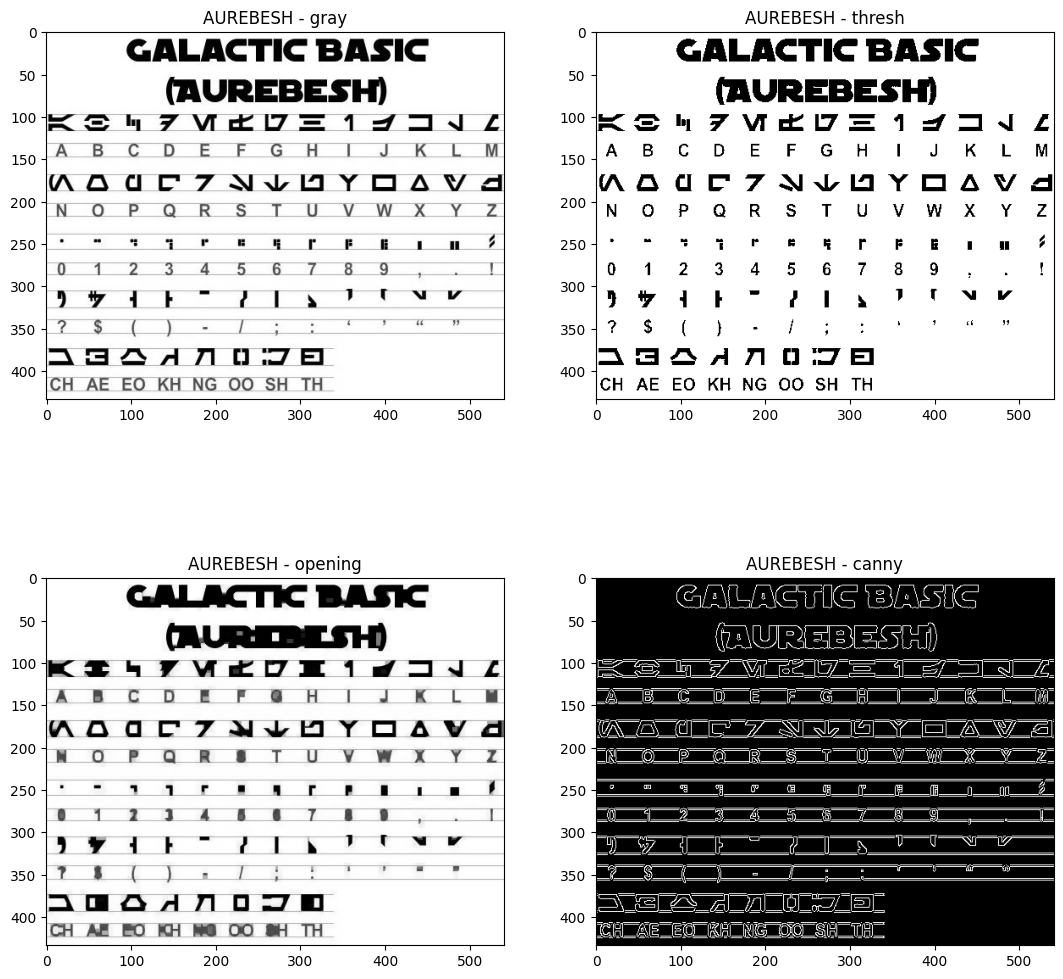

In [ ]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('AUREBESH - ' + keys[i])
    plt.imshow(images[keys[i]], cmap='gray')

Langkah selanjutnya akan kita lakukan ekstraksi data dari images tersebut dengan teknik OCR melalui code berikut

In [ ]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
-------

dari hasil OCR dengan tesseract, maka di dapatkan hasil dari masing image yang telah di pre-processing sebagai berikut

<br>

# Praktikum 2 - Mendapatkan bounding box di sekitar teks pada image

## Deskripsi

Saat menjalankan gambar melalui mesin Tesseract OCR, pytesseract memungkinkan pengguna untuk memperoleh informasi bounding box pada:
1. Tingkat karakter,
2. Tingkat kata,
3. Berdasarkan pola regex.

Pada praktikum ini, akan dijelaskan cara memperoleh kedua jenis informasi tersebut.

## Bounding Box - Level Karakter

Dengan menggunakan Pytesseract, Anda dapat memperoleh informasi bounding box untuk hasil OCR dengan menggunakan kode berikut.

Skrip di bawah ini akan memberikan informasi bounding box untuk setiap karakter yang terdeteksi oleh tesseract selama proses OCR.

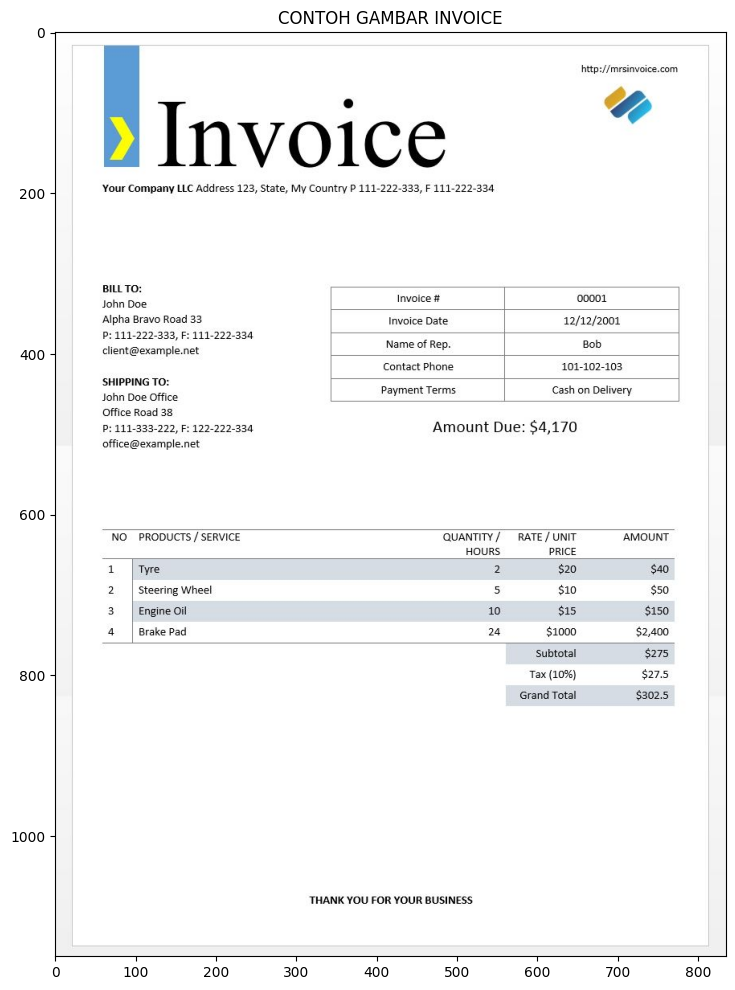

In [ ]:
# Plot gambar original

# Membaca gambar dari direktori
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Memisahkan saluran warna (blue, green, red) karena matplotlib menggunakan skema warna RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dalam ukuran tertentu
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH GAMBAR INVOICE')
plt.show()


Langkah selanjutnya adalah, Plot karakter boxes pada gambar menggunakan fungsi pytesseract.image_to_boxes()

kode program berikut akan memberikan hasil bounding box pada image invoice

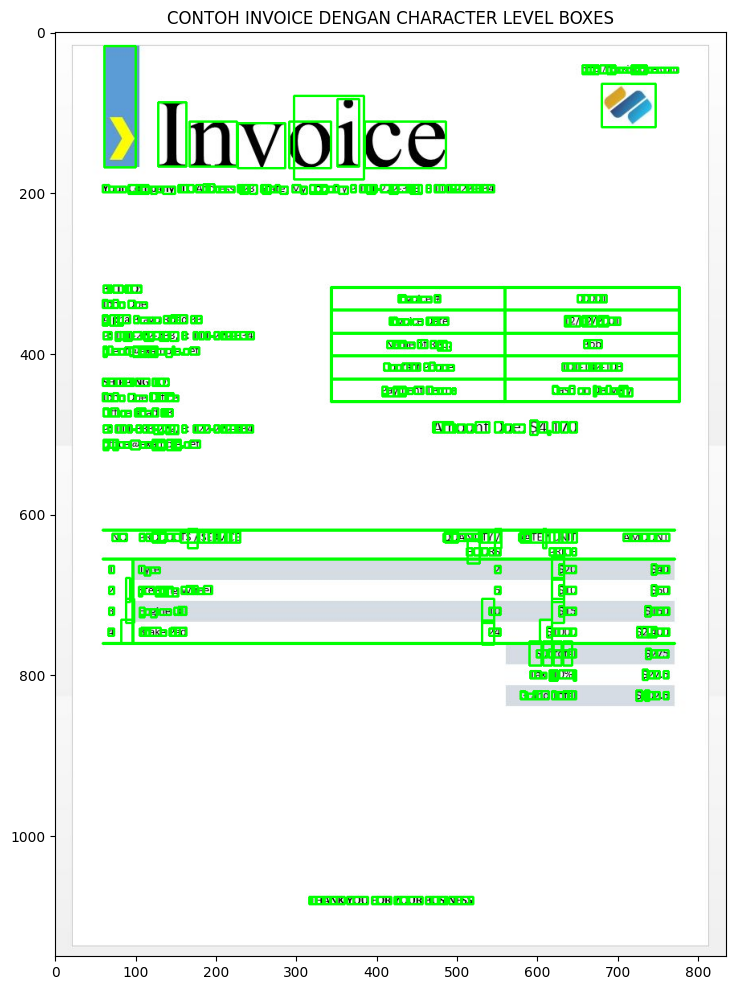

In [ ]:
# Membaca gambar dari direktori
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Mendapatkan dimensi tinggi (h), lebar (w), dan channel warna (c) dari gambar
h, w, c = image.shape

# Menggunakan pytesseract.image_to_boxes() untuk mendapatkan informasi kotak karakter
boxes = pytesseract.image_to_boxes(image)

# Iterasi melalui setiap baris hasil dan membuat kotak pada gambar menggunakan OpenCV
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak karakter
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN CHARACTER LEVEL BOXES')
plt.show()


## Bounding Box - Level Kata

langkah Selanjutnya kita akan menggunakan gambar contoh invoice di atas untuk menguji hasil output dari Tesseract.

Pada Code berikut akan digunakan untuk membaca gambar contoh invoice, kemudian menggunakan fungsi pytesseract.image_to_data() untuk mendapatkan data teks dari gambar.

In [ ]:
# Membaca gambar contoh invoice
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Menggunakan pytesseract.image_to_data() untuk mendapatkan data teks dari gambar
d = pytesseract.image_to_data(image, output_type=Output.DICT)

# Menampilkan kunci-kunci data yang diperoleh dari hasil OCR
print('DATA KEYS: \n', d.keys())


DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


Hasil yang didapatkan seharusnya memberikan output sebagai berikut:

Selanjutnya pada code berikut digunakan untuk memfilter dan hanya menampilkan kotak-kotak kata yang memiliki tingkat kepercayaan (confidence) lebih dari 60%. Hasilnya, gambar contoh invoice akan ditampilkan dengan kotak-kotak yang menandai lokasi setiap kata dengan tingkat kepercayaan yang memenuhi syarat.

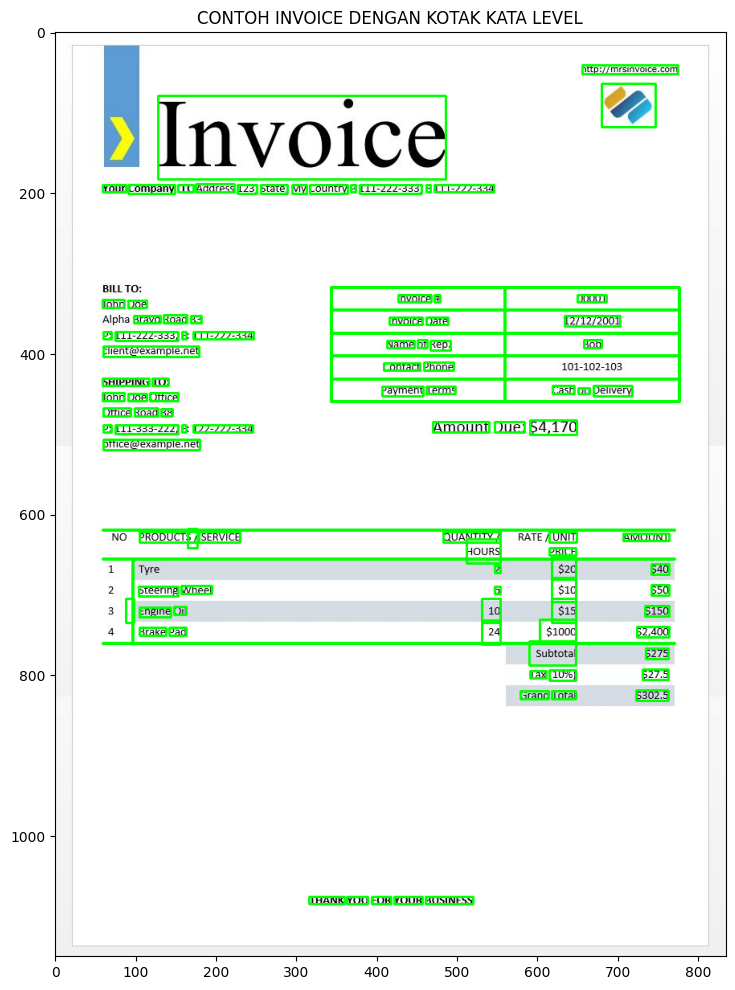

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    # Kondisi untuk hanya memilih kotak dengan kepercayaan > 60%
    if int(d['conf'][i]) > 60:
        # Mendapatkan koordinat dan ukuran kotak kata
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        # Membuat kotak pada gambar untuk kata dengan kepercayaan > 60%
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak kata berdasarkan kepercayaan > 60%
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN KOTAK KATA LEVEL')
plt.show()


## Text template matching - Pola Regex

Misalkan kita ingin menemukan di mana suatu tanggal berada dalam sebuah gambar. Di sini, template yang kita akan gunakan berupa pola ekspresi reguler yang akan kita cocokkan dengan hasil OCR kita untuk menemukan kotak-kotak pembatas yang sesuai. Kita akan menggunakan modul regex dan fungsi image_to_data untuk hal ini.

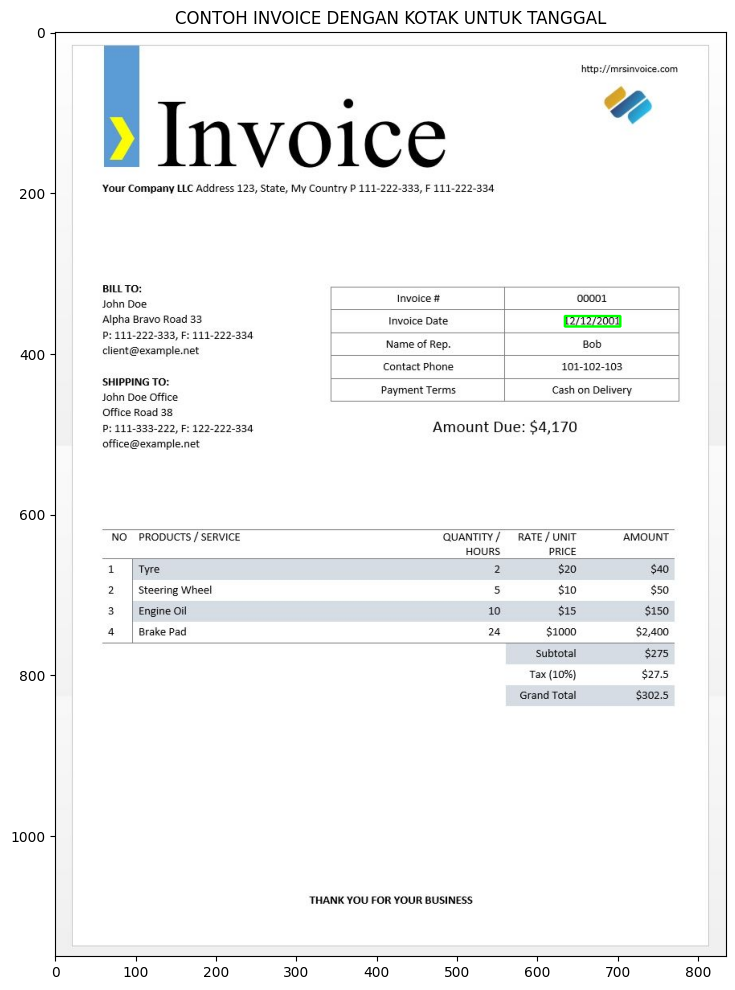

In [ ]:
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Pola tanggal dalam format dd/mm/yyyy
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    # Memeriksa apakah kotak memiliki tingkat kepercayaan lebih dari 60%
    if int(d['conf'][i]) > 60:
        # Memeriksa apakah teks di dalam kotak sesuai dengan pola tanggal
        if re.match(date_pattern, d['text'][i]):
            # Mendapatkan koordinat dan ukuran kotak kata
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            # Membuat kotak pada gambar untuk tanggal yang sesuai dengan pola
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak-kotak yang menandai lokasi tanggal
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN KOTAK UNTUK TANGGAL')
plt.show()


## Deteksi berbagai bahasa - OCR

Anda dapat memeriksa bahasa yang tersedia dan didukung dalam tesseract pada taupan berikut

> Tesseract memiliki dukungan unicode (UTF-8), dan dapat mengenali lebih dari 100 bahasa secara langsung.

Untuk menetapkan bahasa yang diinginkan untuk hasil OCR Anda, gunakan argumen -l LANG dalam konfigurasi di mana LANG adalah kode tiga huruf untuk bahasa yang ingin Anda gunakan.

Kode berikut digunakan untuk membaca dan menampilkan gambar yang berisi teks dalam beberapa bahasa. Gambar asli ditampilkan untuk memberikan gambaran tentang kontennya sebelum proses OCR.

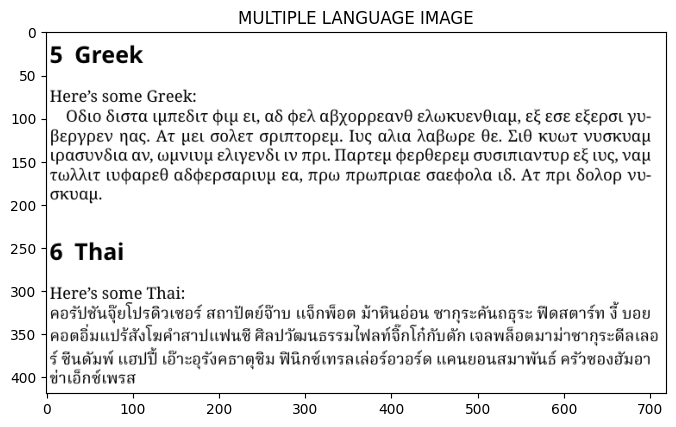

In [ ]:
# Membaca gambar asli
image = cv2.imread(IMG_DIR + 'greek-thai.png')

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar asli
plt.figure(figsize=(8, 16))
plt.imshow(rgb_img, cmap='gray')
plt.title('MULTIPLE LANGUAGE IMAGE')
plt.show()


Selanjutnya, Kode berikut digunakan untuk mengekstrak teks dari gambar dengan menggunakan Tesseract OCR. Konfigurasi khusus (custom_config) diterapkan dengan hanya menentukan bahasa Inggris (-l eng). Parameter lain seperti --oem 3 dan --psm 6 juga digunakan untuk mengoptimalkan hasil OCR sesuai kebutuhan.

In [ ]:
# Output dengan hanya bahasa Inggris yang ditentukan

# Konfigurasi khusus dengan hanya bahasa Inggris yang diatur
custom_config = r'-l eng --oem 3 --psm 6'

# Menggunakan pytesseract.image_to_string() untuk mendapatkan teks dari gambar dengan konfigurasi khusus
print(pytesseract.image_to_string(image, config=custom_config))



5 Greek
Here’s some Greek:

OSto Stota tuMedit Huy et, aS ea aByoppeave edAwkvevOuay, e§ ece efepot yu-
Bepypev nas. AT Wel GoAET apiTtopen. Tug aAta AaBwpe Ve. LO KUWT VUoKLaL
(paovvéia av, WUVLUU eAtyevil tv mpL TMaptep bepSepey GvaTLAaVTUp e€€ LUG, Va
TWAALT LUdaped ASdepoapluy Ea, TOW TpwTplae Gaedoda 16. AT mpt SoAop vv-
oxvau.

6 Thai

Here’s some Thai: .
aosUsugulushawos amiaddw usntioa sinfudou winszduagss Haaonsn 3 vos
Aonduusaladrawunud AavTausssulwavianlAdudn wandoamnsiwinsedataa
$ Guduvi woud rvaseasiadu Windinsadosor0sa uausouanrwus aswouduer
didadinsa



<br>

# Tugas

### Mendeteksi orientasi teks dan jenis skrip

Tugas ini bertujuan untuk mendeteksi orientasi teks dan jenis skrip yang digunakan dalam suatu gambar menggunakan tesseract.

**Tugas**:
1. **Persiapan Gambar**:
  - Gunakan gambar contoh yang disediakan ('hitchhikers-rotated.png').
  - Tampilkan gambar asli menggunakan Python dan OpenCV.
2. **Deteksi Orientasi dan Skrip**:
  - Implementasikan skrip Python untuk mendeteksi orientasi teks dalam gambar.
  - Gunakan Tesseract untuk mendapatkan sudut rotasi (angle) dan jenis skrip (script).
  - Tampilkan hasil orientasi dan jenis skrip.

# Jawaban

1. **Persiapan Gambar**:
  - Gunakan gambar contoh yang disediakan ('hitchhikers-rotated.png').
  - Tampilkan gambar asli menggunakan Python dan OpenCV.

In [6]:
!apt install tesseract-ocr
!apt-get install -y poppler-utils
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [7]:
import re #model ekspresi reguler untuk pencocokan pola atau manipulasi teks
import cv2 #library OpenCV untuk pengolahan gambar
import numpy as np #untuk operasi numerik, data gambar
import pytesseract#untuk pengenalan karakter
from pytesseract import Output#mennetukan opsi
from matplotlib import pyplot as plt#UI untuk membuat plot

In [8]:
IMG_DIR = '/content/drive/MyDrive/ML/Jobsheet 12/images/'

Text(0.5, 1.0, 'HITCHHIKERS ROTATED IMAGE')

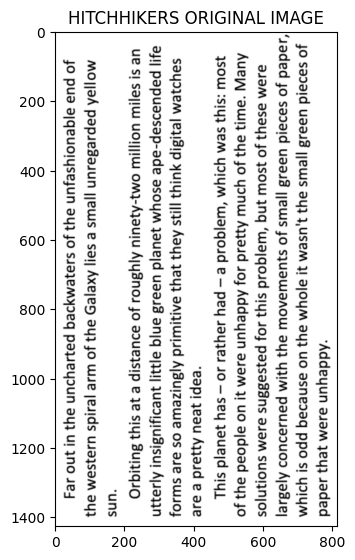

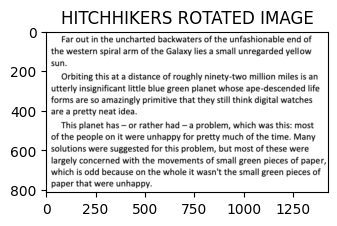

In [9]:
# get grayscale image
def get_grayscale(image):#konversi citra berwana ke citra grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):#menghilangkan noise dari citra
    return cv2.medianBlur(image,5)#menggunakan media lur dengan kernal ukuran 5x5(menghaluskan citra dan menghilangkan titik noise)

#thresholding
def thresholding(image):#Tresholding intuk menghasilkan citra biner
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]#menggnakan metode otsu

#dilation
def dilate(image):#dilasi untuk memperbesar objek pada citra
    kernel = np.ones((5,5),np.uint8)#menggunakan kernel persegi 5x5
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):#erosi untuk mengurangi ukuran objek pada citra
    kernel = np.ones((5,5),np.uint8)#menggunakan kernel persegi 5x5
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):#operasi opening morfologi dari dilasi diikuti erosi. untuk mengurangi noise dan memisahkan objek yang berdekatan
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):#deteksi tepi Canny
    return cv2.Canny(image, 100, 200)# Canny untuk menemukan tepi pada gambar, 100 dan 200 ambang bawah dan atas untuk tepi

#skew correction
def deskew(image):#koreksi kemiringan
    coords = np.column_stack(np.where(image > 0))#cari koordinat piksel yang punya nilai lebih besar dari 0
    angle = cv2.minAreaRect(coords)[-1]#get sudut kemiringan, -1 untuk ambul elemen terakhir dari tuple
    if angle < -45:#periksa sudut kemiringan
        angle = -(90 + angle)#jika kurang dari 45, sudut diubah dengan rumus ini(lebih kecil atau samadengan -45)
    else:
        angle = -angle
    (h, w) = image.shape[:2]#ambil tinggi dan lebar
    center = (w // 2, h // 2)#hitung titik tengah
    M = cv2.getRotationMatrix2D(center, angle, 1.0)#get matriks rotasi
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)#wrap affine, hasilnya gambar yang sudah dikoreksi kemiringannya
    return rotated#mengembalikan gambar

#template matching
def match_template(image, template):#penccokan template antar gambar input dan template
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)#mengembalikan hasil pencocokan


# Plot original image
image = cv2.imread(IMG_DIR + 'hitchhikers-rotated.png')

#untuk rotasi image
image_rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

#pisah 3 warna jadi RGB
b,g,r = cv2.split(image_rotated)
rgb_img = cv2.merge([r,g,b])

#menampilkan original image
plt.figure(figsize=(8,8))
plt.subplot(121),plt.imshow(image)
plt.title('HITCHHIKERS ORIGINAL IMAGE')

#menampilkan rotated image
plt.figure(figsize=(8,8))
plt.subplot(122),plt.imshow(rgb_img)
plt.title('HITCHHIKERS ROTATED IMAGE')

In [10]:
# Preprocess image

gray = get_grayscale(image_rotated)#citra keabuan dari gambar
thresh = thresholding(gray)#tresholding(menjadi citra biner) pada citra keabuan
opening = opening(gray)#operasi morphological opening pada citra keabuan
canny = canny(gray)#melakukan deteksi tepi
images = {'gray': gray,#simpan hasil pemrosesan dlm bentuk kampus
          'thresh': thresh,
          'opening': opening,
          'canny': canny}

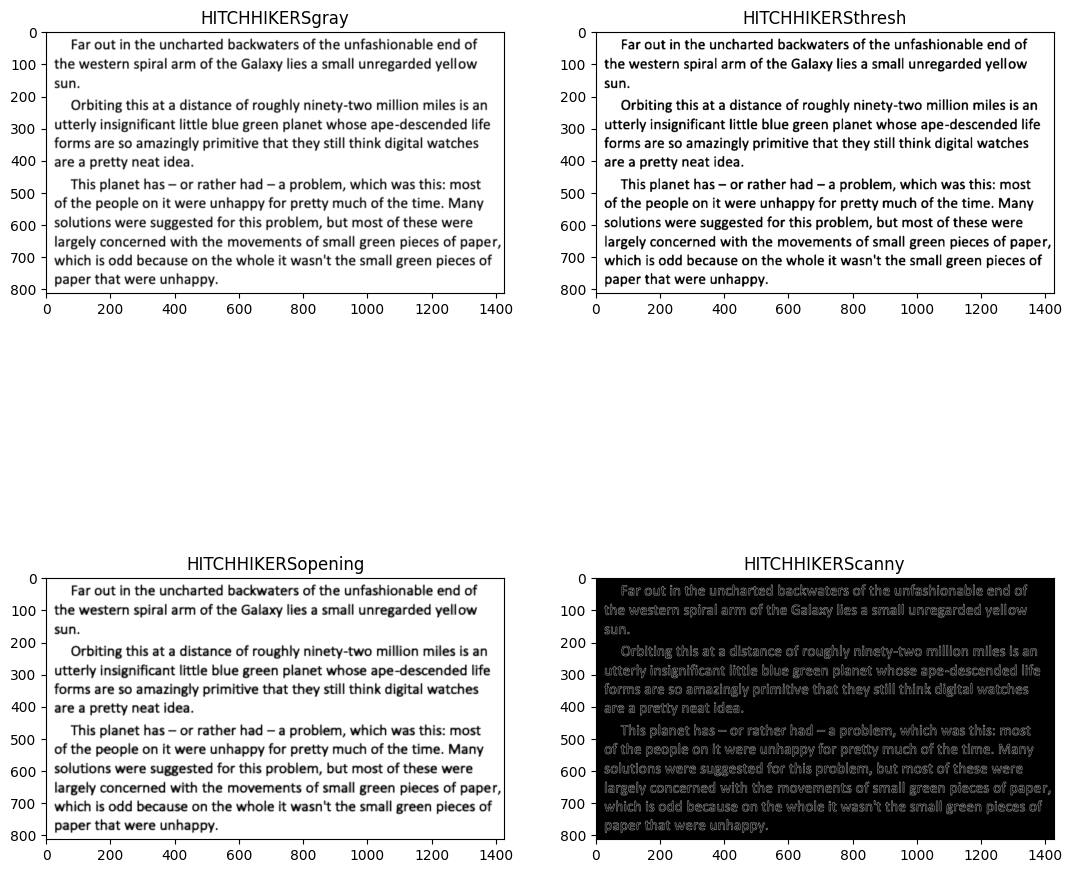

In [11]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))#buat objek gambar
ax = []#untuk menyimpan objek subplot

rows = 2#define baris
columns = 2#define kolom
keys = list(images.keys())#get daftar keys dari gambar
for i in range(rows*columns):#iterasi sebanyak jumlah baris x kolom
    ax.append( fig.add_subplot(rows, columns, i+1) )#tambah subplot dan menentuka lokasi subplot pada gambar
    ax[-1].set_title('HITCHHIKERS' + keys[i])#memberi judul
    plt.imshow(images[keys[i]], cmap='gray')#menampilkan gambar yang sudah dalam citra keabuan

2. **Deteksi Orientasi dan Skrip**:
  - Implementasikan skrip Python untuk mendeteksi orientasi teks dalam gambar.
  - Gunakan Tesseract untuk mendapatkan sudut rotasi (angle) dan jenis skrip (script).
  - Tampilkan hasil orientasi dan jenis skrip.

### Deteksi Rotasi Sebelum Dirotasi

In [12]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))#OCR  pada gambar asli
print('\n-----------------------------------------')

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
-
w os
- St wu + 2 a °
oe = @ YOoOg on
°o Yue ome cqw
T= wn Vo ESve @G
oY ota wo SF OS
— nw
vo Eos ceee¢oe
= oOo _ En y
a oO a a + = o oO
so Caf or coc UVa
o Oo pa
Co = 9 & S2o2°% Mw
S$ Ee0 ZS 3 Es
ws a x Stuaé
£5 Qwest feo OMG
c Sus Soe
S= #388 SER?
fs FSS EEBER
Sa vo; YV>m ae
Oo w ce OU G o
gy 2 +A2S aanvs
= a c
> $28 o5 85H
& > os |f ae
s = og o>u oO
x<~ © - © W oO Sc
oOo WM _- o> ac
= <= ~ Os
So 9 ae ~«§ SLE
cx a a ofo w
32 cat $528 y
e
ro So? fBagteca
Co ¢ SEF. ce grnse?re
Sec sbEewpgosutevs
<c & or in | F MSG
> es CN= gH Meas
w@ & SER ®SCHAVZ YD
© 38 Y= a@f£OoqgEPs
=- & - 2 wa
~~” cic crore Gg
coc Seger eaoys
—_ i. —_
+ Oo ~ayb oO 5 0%
a 4+ = £Lc ved ¥ x
on Sr Bet acVus
. ¥ BS2z>yvart*BZyglFert
oF .S5E*C SCL GSS
uw c OW ree Sd m=z a
25 B52 -¥ oka
$a S26 on Sa


-----------------------------------------


In [13]:
import cv2
import pytesseract
from PIL import Image#untuk open, manipuliasi, dan simpan image dlm berbagai format

def get_text_orientation(image):#menerima citra sebagai input
    # Convert NumPy array ke PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    try:
        # pakai tesseract OCR untuk merotasi
        details = pytesseract.image_to_osd(pil_image)#untuk mendapatkan informasi sudut rotasi
        rotation_angle = float(details.split("\n")[1].split(":")[1])
        print(f"Sudut Rotasi dari OCR: {rotation_angle} derajat")
        return rotation_angle
    except Exception as e:
        print(f"Error: {e}")
        return None

# Get the rotation angle
rotation_angle = get_text_orientation(image)

if rotation_angle is not None:#cetak sudut rotasi jika hasilnya tidak none
    print(f"Sudut Rotasi: {rotation_angle} derajat")

Sudut Rotasi dari OCR: 270.0 derajat
Sudut Rotasi: 270.0 derajat


### Deteksi Orientasi dan Skrip Sesudah Dirotasi

In [14]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image_rotated, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image_rotated, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image_rotated, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image_rotated, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
Far out in the uncharted backwaters of the unfashionable end of
the western spiral arm of the Galaxy lies a small unregarded yellow
sun.

Orbiting this at a distance of roughly ninety-two million miles is an
utterly insignificant little blue green planet whose ape-descended life
forms are so amazingly primitive that they still think digital watches
are a pretty neat idea.

This planet has — or rather had — a problem, which was this: most
of the people on it were unhappy for pretty much of the time. Many
solutions were suggested for this problem, but most of these were
largely concerned with the movements of small green pieces of paper,
which is odd because on the whole it wasn't the small green pieces of
paper that were unhappy.


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
Far out in the 

In [15]:
import cv2
import pytesseract
from PIL import Image#untuk open, manipuliasi, dan simpan image dlm berbagai format

def get_text_orientation(image):#menerima citra sebagai input
    # Convert NumPy array ke PIL Image
    pil_image = Image.fromarray(cv2.cvtColor(image_rotated, cv2.COLOR_BGR2RGB))

    try:
        # pakai tesseract OCR untuk merotasi
        details = pytesseract.image_to_osd(pil_image)#untuk mendapatkan informasi sudut rotasi
        rotation_angle = float(details.split("\n")[1].split(":")[1])
        print(f"Sudut Rotasi dari OCR: {rotation_angle} derajat")
        return rotation_angle
    except Exception as e:
        print(f"Error: {e}")
        return None

# Get the rotation angle
rotation_angle = get_text_orientation(image_rotated)

if rotation_angle is not None:#cetak sudut rotasi jika hasilnya tidak none
    print(f"Sudut Rotasi: {rotation_angle} derajat")

Sudut Rotasi dari OCR: 0.0 derajat
Sudut Rotasi: 0.0 derajat
